In [6]:
# Import libraries
import torch
print('torch ver: ', torch.__version__)
from torchvision import datasets, transforms

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,)),]) 
trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)
testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)
image, label = trainset[0] 
print("image shape: ", image.shape) # torch.Size([1, 28, 28])
print("# labels: ", len(testset.classes))
print(testset.class_to_idx)

torch ver:  2.0.0
image shape:  torch.Size([1, 28, 28])
# labels:  10
{'T-shirt/top': 0, 'Trouser': 1, 'Pullover': 2, 'Dress': 3, 'Coat': 4, 'Sandal': 5, 'Shirt': 6, 'Sneaker': 7, 'Bag': 8, 'Ankle boot': 9}


In [7]:
# Final sizes are 50000, 10000, 10000
trainset, valset = torch.utils.data.random_split(trainset, [50000, 10000])
print(f'Train set size: {len(trainset)}, Validation set size: {len(valset)}, Test set size: {len(testset)}')
# Shuffle the data at the start of each epoch (only useful for training set)
batchsize = 128 # was 32
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batchsize, shuffle=True)
val_loader = torch.utils.data.DataLoader(valset, batch_size=batchsize, shuffle=False)
test_loader = torch.utils.data.DataLoader(testset, batch_size=batchsize, shuffle=False)

Train set size: 50000, Validation set size: 10000, Test set size: 10000


MPS is built? True
k=10
used 40 iterations (0.7043s) to cluster 50000 items into 10 clusters
Visualize the centroids...


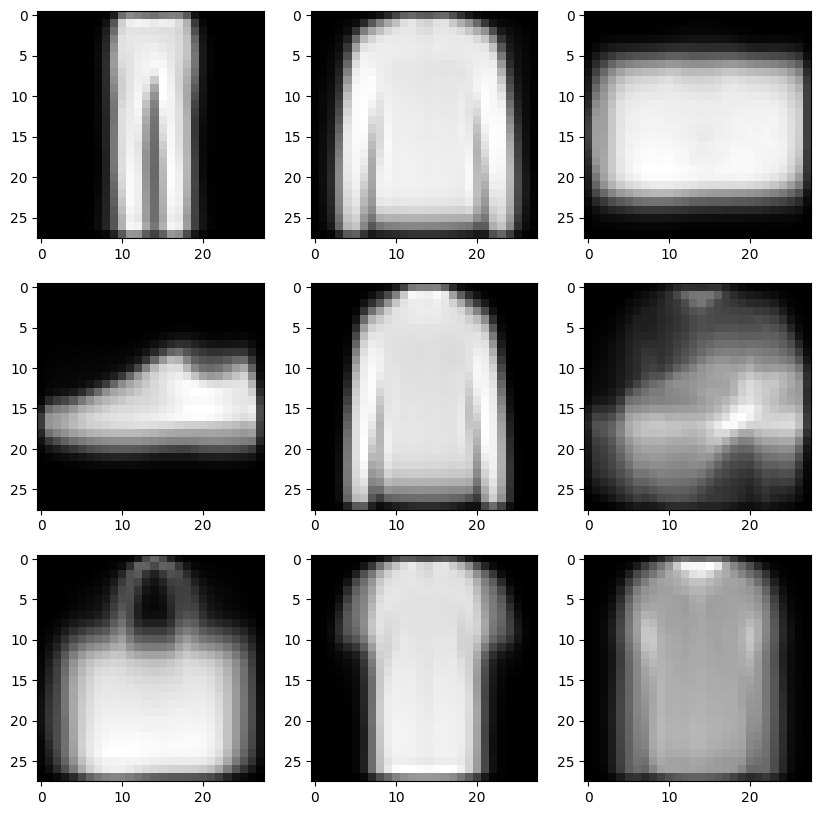

Centroids saved to ./centroids/torch-k=10.pt (shape: (10, 784))


In [8]:
# kmeans clustering on train data
from utils.cluster import get_centroids

print("MPS is built?", torch.backends.mps.is_built())
# k_list = [10, 20, 40, 80, 160]
k_list = [10]
d = 'cpu'
d = 'mps'
for n_clusters in k_list:
    print(f"k={n_clusters}")
    kmeans, centroids = get_centroids(n_clusters, train_loader, device=d, save=True, vis=True)

In [9]:
# check if file exists with the substring k=10
import os
DIR = './centroids'
SAVENAME = f'{DIR}/fmnist/torch-k={n_clusters}.pt'
if os.path.exists(SAVENAME):
    centroids = torch.load(SAVENAME)


In [10]:
import numpy as np

# flatten the tensor except batch dim
flatten = lambda x : x.view(x.size(0), -1).numpy()
# which image is assigned to which cluster?
assignments = []
for image, target in train_loader:
    feat = flatten(image)
    # (K, D) @ (D, N) -> (K, N).argmax() -> (N,)
    closest = np.argmax(centroids @ feat.T, axis=0)
    assignments.extend(closest)

cluster 0 has 2 images
cluster 1 has 12009 images
cluster 2 has 7950 images
cluster 3 has 1222 images
cluster 4 has 7062 images
cluster 5 has 2621 images
cluster 6 has 2565 images
cluster 7 has 9619 images
cluster 8 has 1636 images
cluster 9 has 5314 images


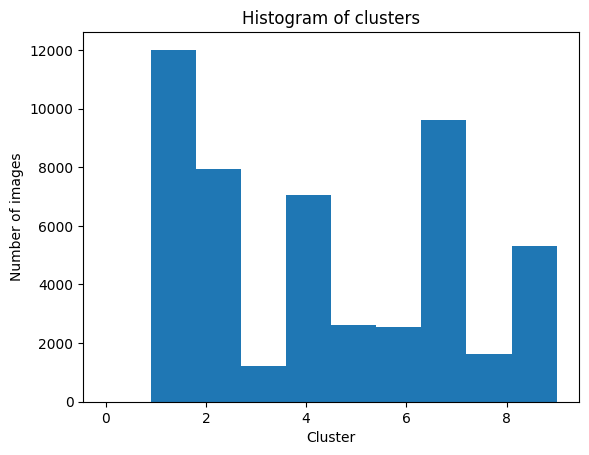

In [11]:
# create a nested list according to assignments
def fetch(data_loader, indices):
    all_data = list(data_loader.dataset)  # Convert the dataset to a list
    fetched_images = [all_data[i] for i in indices]
    return fetched_images

# group (image, target) pairs 
clustered_dataset = [[] for i in range(10)]
for i in range(10):
    idx = np.where(np.array(assignments) == i)[0]
    print(f"cluster {i} has {len(idx)} images")
    imgs = fetch(train_loader, idx)
    clustered_dataset[i] = imgs

from utils.cluster import plot_histogram
plot_histogram(assignments)

In [12]:
import random
#create dataset with 50% of data
data_dict_50 = {}
index = 0
for i in range(10):
    num_items = len(clustered_dataset[i])
    num_selected = len(clustered_dataset[i])/2
    #select random indices
    selected_indices = random.sample(range(num_items), int(num_selected))
    for j in selected_indices:
        data_dict_50[index] = {'images': clustered_dataset[i][j][0], 'labels': clustered_dataset[i][j][1]}
        index = index+1

print('new train data length', len(data_dict_50))

from utils.dataset import DictDataset
custom_dataset = DictDataset(data_dict_50)
# Create the dataloader for the train dataset
dedup_train_loader = torch.utils.data.DataLoader(custom_dataset, batch_size=128, shuffle=True)

SAVE = True
if SAVE:
    # save loader in torch
    torch.save(dedup_train_loader, f'./loaders/fmnist/dedup_train@k={n_clusters}.pt')

new train data length 24998
